In [162]:
import json
import pandas as pd
import numpy as np  
import os
import random

from metric import r_precision, dcg_at_k, ndcg_at_k
from utils import generate_playlists, generate_testcases

from numpy import linalg as LA

import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
import collections

import lightgbm as lgb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [163]:
path_to_data = '/content/drive/MyDrive/DO_AN_KHDL/DATA'
path_audio_feats = os.path.join(path_to_data, 'audio_features.tsv')
path_playlists = os.path.join(path_to_data, 'playlists.tsv')
path_tracks = os.path.join(path_to_data, 'tracks.tsv')

In [164]:
pd_audio_feats = pd.read_csv(path_audio_feats, sep = '\t')
pd_tracks = pd.read_csv(path_tracks, sep = '\t')
pd_playlists = pd.read_csv(path_playlists, sep = '\t')
pd_playlists = pd_playlists.fillna('None')

In [165]:
pd_tracks = pd.merge(pd_tracks, pd_audio_feats, left_on = 'track_id', right_on = 'id')
pd_full = pd.merge(pd_tracks, pd_playlists, left_on = 'playlist_id', right_on = 'playlist_id')

pd_tracks = pd_tracks.drop('id', 1)
pd_full = pd_full.drop('playlist_name_y', 1)
pd_full = pd_full.drop('id', 1)

In [166]:
pd_full.shape

(86400, 27)

In [167]:
#Thông tin rỗng là discription, ta có thể chỉ điền vào "None"
pd_full = pd_full.fillna('None')

In [168]:
#Kiểm tra và bỏ giá trị trùng lặp
pd_full = pd_full.drop_duplicates()

In [169]:
pd_full.shape

(86350, 27)

In [170]:
pd_full['available_markets'] = pd_full['available_markets'].apply(lambda x : x[1:-1].split(', '))
pd_full['count_available_markets'] = pd_full['available_markets'].apply(lambda x : len(x))

In [171]:
pd_full.head()

,track_id,track_name,playlist_id,playlist_name_x,artist_ids,artist_names,album_id,album_name,track_duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,analysis_url,time_signature,available_markets,popularity,description,num_tracks,num_followers,count_available_markets
0,463CkQjx2Zk1yXoBuierM9,Levitating (feat. DaBaby),37i9dQZF1DXcBWIGoYBM5M,Today's Top Hits,"['6M2wZ9GZgrQXHCFfjv46we', '4r63FhuTkUYltbVAg5...","['Dua Lipa', 'DaBaby']",04m06KhJUuwe1Q487puIud,Levitating (feat. DaBaby),203064,0.702,0.825,6,-3.787,0,0.0601,0.00883,0.00000,0.0674,0.915,102.977,https://api.spotify.com/v1/audio-analysis/463C...,4,"['AD', 'AE', 'AL', 'AR', 'AU', 'BA', 'BE', 'BG...",90,Dua Lipa & DaBaby are on top of the Hottest 50!,50,27084233,88
1,7igeByaBM0MgGsgXtNxDJ7,positions,37i9dQZF1DXcBWIGoYBM5M,Today's Top Hits,['66CXWjxzNUsdJxJ2JdwvnR'],['Ariana Grande'],3jqEvfiu2ENgmgzZq27zbi,positions,172324,0.736,0.802,0,-4.759,1,0.0864,0.46800,0.00000,0.0940,0.675,144.005,https://api.spotify.com/v1/audio-analysis/7ige...,4,[],76,Dua Lipa & DaBaby are on top of the Hottest 50!,50,27084233,1
2,0lx2cLdOt3piJbcaXIV74f,willow,37i9dQZF1DXcBWIGoYBM5M,Today's Top Hits,['06HL4z0CvFAxyc27GXpf02'],['Taylor Swift'],2Xoteh7uEpea4TohMxjtaq,evermore,214706,0.392,0.574,7,-9.195,1,0.1700,0.83300,0.00179,0.1450,0.529,81.112,https://api.spotify.com/v1/audio-analysis/0lx2...,4,"['AD', 'AE', 'AL', 'AR', 'AT', 'AU', 'BA', 'BE...",91,Dua Lipa & DaBaby are on top of the Hottest 50!,50,27084233,91
3,2Z8yfpFX0ZMavHkcIeHiO1,Monster (Shawn Mendes & Justin Bieber),37i9dQZF1DXcBWIGoYBM5M,Today's Top Hits,"['7n2wHs1TKAczGzO7Dd2rGr', '1uNFoZAHBGtllmzznp...","['Shawn Mendes', 'Justin Bieber']",3yVVL2EYLp8g7gT08VvYKy,Monster,178994,0.652,0.383,2,-7.076,0,0.0516,0.06760,0.00000,0.0828,0.549,145.765,https://api.spotify.com/v1/audio-analysis/2Z8y...,4,"['AD', 'AE', 'AL', 'AR', 'AT', 'AU', 'BA', 'BE...",93,Dua Lipa & DaBaby are on top of the Hottest 50!,50,27084233,91
4,6zFMeegAMYQo0mt8rXtrli,HOLIDAY,37i9dQZF1DXcBWIGoYBM5M,Today's Top Hits,['7jVv8c5Fj3E9VhNjxT4snq'],['Lil Nas X'],4EvukZrmNBiqJbs3LwOSHu,HOLIDAY,154997,0.810,0.511,5,-6.924,0,0.1640,0.12000,0.00000,0.0832,0.837,151.947,https://api.spotify.com/v1/audio-analysis/6zFM...,4,"['AD', 'AE', 'AL', 'AR', 'AT', 'AU', 'BA', 'BE...",93,Dua Lipa & DaBaby are on top of the Hottest 50!,50,27084233,92


## k-means

**Ý tưởng model**: Với mỗi input là playlist hiện có **N** bài hát,

### create test-cases

In [172]:
fraction = 3
nums_playlists_test = 100

track_id_all = generate_playlists(pd_full, pd_playlists, nums_playlists_to_test = nums_playlists_test)
track_id_test = generate_testcases(track_id_all, fraction = fraction)

In [173]:
all_playlistID_for_tests = list(track_id_test.keys())

In [174]:
pd_full_tests = pd_full.copy()
pd_full_tests = pd_full_tests[pd_full_tests['playlist_id'].isin(all_playlistID_for_tests)]
pd_full_tests = pd_full_tests.reset_index(drop = True)
pd_full_tests_copy = pd_full_tests.copy()

In [175]:
omit_feats = ['track_id', 'track_name', 'playlist_id', 'playlist_name_x','artist_ids', 'artist_names', 'album_id', 'album_name', 'analysis_url', 'description', 'num_followers', 'available_markets', 'num_tracks']
pd_full_tests_copy = pd_full_tests_copy.drop(omit_feats, 1)

### modeling

#### tìm số cụm tốt nhất ứng với data?

In [176]:
# Standardizing the data
scaler = MinMaxScaler()
scaler.fit(pd_full_tests_copy)
pd_playlists_numeric_scaled = scaler.transform(pd_full_tests_copy)

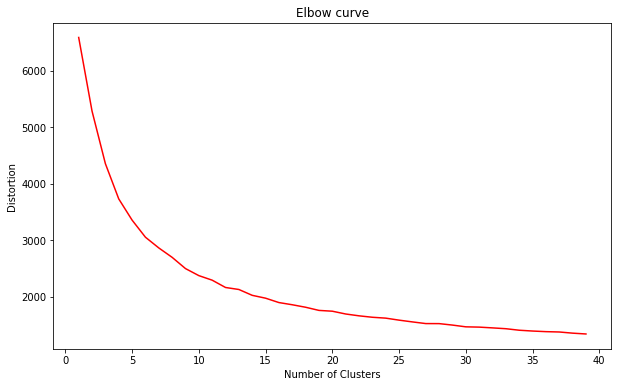

In [177]:
distortion = []
n_clusters = 40

for k in range(1, n_clusters):  
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(pd_playlists_numeric_scaled)
    distortion.append(kmeans.inertia_)

fig = plt.figure(figsize=(10, 6))
plt.plot(range(1, n_clusters), distortion, c = 'red')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.title('Elbow curve')
plt.show()

**Nhận xét**: theo nguyên tắc Elbow (khuỷu tay) trong phân cụm, ta thấy số cụm tốt nhất ứng với dữ liệu nằm trong khoảng 6-8. Ở đây nhóm em chọn số cụm là 7.

#### tạo k-means model với số cụm tốt nhất (k=7)

In [178]:
kmeans = KMeans(n_clusters = 7)
kmeans.fit(pd_playlists_numeric_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [179]:
label = kmeans.labels_
pd_full_tests_copy['cluster_label'] = label

In [180]:
pd_full_tests_copy.head()

,track_duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,popularity,count_available_markets,cluster_label
0,154997,0.810,0.511,5,-6.924,0,0.1640,0.120,0.000000,0.0832,0.837,151.947,4,93,92,1
1,174321,0.889,0.340,11,-7.773,0,0.0697,0.218,0.130000,0.0550,0.716,94.009,4,96,92,1
2,160000,0.709,0.548,10,-8.493,1,0.3530,0.650,0.000002,0.1330,0.543,83.995,4,95,92,0
3,140525,0.700,0.722,7,-3.558,0,0.0369,0.221,0.000000,0.2720,0.756,90.989,4,98,92,1
4,163208,0.767,0.659,1,-7.429,1,0.0444,0.325,0.000000,0.1300,0.439,124.946,4,89,91,3


In [181]:
def generate_songs_kmeans(playlist, df_scaled_features, info_df, n_pred, num_clusters = 7, random_state = 2711):
    pid = list(info_df[info_df['track_id'].isin(playlist)]['playlist_id'].value_counts().index)
    if (len(pid) == 0):
      print(playlist)
    else:
      pid = pid[0]
    df_k = pd.DataFrame(df_scaled_features.copy())

    kmeans = KMeans(n_clusters = num_clusters, random_state = random_state)
    kmeans.fit(df_k)
    
    label = kmeans.labels_
    df_k['cluster_label'] = label
    
    mode_cluster = list(df_k[info_df['playlist_id'] == pid]['cluster_label'].value_counts().index)[0]
    
    our_df = info_df[~(info_df['track_id'].isin(playlist)) & (df_k['cluster_label'] == mode_cluster)]
    our_df = our_df.sort_values(by = 'popularity', ascending=False)

    recs_names = list(np.unique(our_df['track_name'].values))
    preds = collections.Counter(recs_names).most_common(n_pred)
    pred_titles = [p[0] for p in preds]
    return pred_titles

### testing

**Bây giờ ta sẽ thử test phương pháp này trên playlist đầu tiên của tập test**

In [182]:
playlists_to_test = all_playlistID_for_tests[0]

In [183]:
all_name_songs = list(pd_full[pd_full['track_id'].isin(track_id_all[playlists_to_test])]['track_name'].values)
given_songs_name = list(pd_full[pd_full['track_id'].isin(track_id_test[playlists_to_test])]['track_name'].values)

In [184]:
track_name_result = generate_songs_kmeans(track_id_test[playlists_to_test], pd_playlists_numeric_scaled, pd_full_tests, len(track_id_all[playlists_to_test])-len(track_id_test[playlists_to_test]))

In [185]:
print('Songs given: ', given_songs_name, '\n')
print('Songs recommended: ', track_name_result, '\n')

Songs given:  ['Georgia Drumbeat - Instrumental', 'Alpine Star', 'Here Too Far', 'La Mer Peu Profonde', 'The Beekeeper', 'Hat of Rain', 'Neglect', 'Splintered - Instrumental', 'Goodbye, Honey, You Call That Gone', 'Neglect', 'Impossible Air', 'Cloud Corner', 'Here Too Far', 'Shadrach', 'On the Atlantic Ocean', 'Alpine Star', 'Here Too Far', 'Static Orphans', 'The Cascades', 'Instrumental II', 'Exploding', 'Green Arrow', 'Leather and Lace', 'Buho', 'Static Orphans', 'The Cascades', 'Instrumental II', 'Exploding', 'Green Arrow', 'Leather and Lace', 'Buho', 'Old Friend - Instrumental', 'Hat of Rain', 'Goodbye, Honey, You Call That Gone', 'Georgia Drumbeat - Instrumental', 'Neglect', 'Alpine Star', 'Splintered - Instrumental', 'Impossible Air', 'Cloud Corner', 'Unspecified Bird Calls', 'White Horses - Instrumental', 'Twins', 'Undefined', 'Cascade', 'South Australian Border', 'Here Too Far', 'Shadrach', 'La Mer Peu Profonde', 'On the Atlantic Ocean', 'Across White Oak Mountain', 'Interlude'

**Bây giờ ta sẽ sử dụng tất cả 100 playlists trong bộ test để đánh giá**

In [159]:
def test_multi_feats(pd_playlists, pd_full, fraction = 5, nums_playlists_test = 100):
  r_score = []

  track_id_all = generate_playlists(pd_full, pd_playlists, nums_playlists_to_test = nums_playlists_test)
  track_id_test = generate_testcases(track_id_all, fraction = fraction)

  all_playlistID_for_tests = list(track_id_test.keys())

  pd_full_tests = pd_full.copy()
  pd_full_tests = pd_full_tests[pd_full_tests['playlist_id'].isin(all_playlistID_for_tests)]
  pd_full_tests = pd_full_tests.reset_index(drop = True)

  pd_full_tests_copy = pd_full_tests.copy()
  omit_feats = ['track_id', 'track_name', 'playlist_id', 'playlist_name_x','artist_ids', 'artist_names', 'album_id', 'album_name', 'analysis_url', 'description', 'num_followers', 'available_markets', 'num_tracks']
  pd_full_tests_copy = pd_full_tests_copy.drop(omit_feats, 1)

  # Standardizing the data
  scaler = MinMaxScaler()
  scaler.fit(pd_full_tests_copy)
  pd_playlists_numeric_scaled = scaler.transform(pd_full_tests_copy)

  for each_playlist in all_playlistID_for_tests:
    if (len(track_id_test[each_playlist]) == 0):
      print(each_playlist)
    track_name_result = generate_songs_kmeans(track_id_test[each_playlist], pd_playlists_numeric_scaled, pd_full_tests, len(track_id_all[each_playlist])-len(track_id_test[each_playlist]))

    all_name_songs = list(pd_full_tests[pd_full_tests['track_id'].isin(track_id_all[each_playlist])]['track_name'].values)
    given_songs_name = list(pd_full_tests[pd_full_tests['track_id'].isin(track_id_test[each_playlist])]['track_name'].values) 
    test_songs_name = [x for x in all_name_songs if x not in given_songs_name]

    r_score.append(r_precision(track_name_result, test_songs_name))

  return r_score

In [160]:
r_score = test_multi_feats(pd_playlists, pd_full, fraction = 5, nums_playlists_test = 100)

print("Average R precision: " + str(np.mean(r_score)))
print("Max R precision: " + str(np.max(r_score)))

37i9dQZF1DWYHkSks5rujC
[]


ValueError: ignored

In [161]:
pd_playlists[pd_playlists['playlist_id'] == '37i9dQZF1DWYHkSks5rujC']

,playlist_id,playlist_name,description,num_tracks,num_followers
223,37i9dQZF1DWYHkSks5rujC,Perfume Genius: Pride,A journey through The Beatles' career.,50,193649


**Test model trên những fraction khác nhau**:

Fraction là tỷ lệ bài hát hiện có trong mỗi playlist, ta dựa vào chúng để đề xuất các bài hát còn lại, ví dụ playlist có 100 bài hát, ta dùng 1/5 số đó (20 bài hát) để dựa vào đó đề xuất 80 bài hát còn lại.

Fraction có giá trị càng bé hoặc càng lớn thì tỷ lệ đề xuất trúng càng thấp.

Ở đây ta test model với các fraction lần lượt là 2 - 10, tức là trong một playlist có 100 bài hát thì ta sẽ dùng 50, 100/3, 25, ..., 10 bài hát đầu tiên để đề xuất số bài hát còn lại.

In [ ]:
fraction_to_test = list(np.arange(2, 11))

result_mean = {}
result_max = {}

for fraction in fraction_to_test:
  r_score = test_multi_feats(pd_playlists, pd_full, fraction = fraction, nums_playlists_test = 100)
  result_mean[fraction] = np.mean(r_score)
  result_max[fraction] = np.max(r_score)
  print('-'*30)
  print(f'fraction {fraction}:')
  print("Average R precision: " + str(np.mean(r_score)))
  print("Max R precision: " + str(np.max(r_score))) 
  print('-'*30)

In [ ]:
sns.barplot(x=list(result_mean.keys()), y=list(result_mean.values()))

In [ ]:
sns.barplot(x=list(result_max.keys()), y=list(result_max.values()))

**Nhận xét**: 

Kết quả **Average R precision** giảm dần khi giá trị fraction tăng từ 2 - 10, tức là số lượng bài hát input dùng để đề xuất càng nhiều thì model hoạt động càng tốt. Tuy nhiên nhìn chung **Average R precision** vẫn còn khá thấp (< 1 %), tức là tỷ lệ đề xuất trung bình 

Kết quả **Max R precision** biến động hơn so với giá trị **Average R precision**, có một số playlist đề xuất được đúng khá nhiều bài hát (**Max R precision** khi **fraction = 2** lên tới gần 0.06).